In [1]:
using Distributions, PyPlot, HypothesisTests
include("../KPNormal.jl")

/Users/vishalgupta/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


KP

In [ ]:
n = 10
thetas = randn(n) / sqrt(2)

vs = rand(n) * 4
zs = randn(n) ./ sqrt(vs) + thetas
cs = rand(n) * 20

dot(zs, q(cs, zs))/n

### Is sup_tau Z' q(tau, Z) is Lipschitz in Z?
It's not for a fixed tau.  (Not even continuous.)  Probably not for sup either, depsite plot.  

In [ ]:
## Plot the sup_tau 1/n Z' q(tau, Z) as a fcn of Z[indx]
indx = 2
z_grid = linspace(-4, 4, 20)/sqrt(vs[indx]) + thetas[indx]
out = zeros(z_grid)
out_q = zeros(z_grid)
for (ix, z) in enumerate(z_grid)
    zs[indx] = z
    max_qs, taus_vals, objs = best_q_tau(cs, zs, vs, zs)
    out[ix] = dot(zs, max_qs)/n
    out_q[ix] = max_qs[indx]    
end
plot(z_grid, out, "s-b")

### Is Z'q(tau, Z) smooth in tau?  
No.  R(tau, Z), ' q(tau, Z) will be smooth

### Is the rademacher average the same in distribution?
KS test suggests no.  Which makes sense.  Because it seems to critically require independence.  

In [ ]:
n = 10
thetas = randn(n) / sqrt(2)
vs = rand(n) * 4
cs = rand(n) * 20

tau = 1

#fix a single rademacher sequence
rads = float(rand(n) .> .5)
numSims = 100000
out = zeros(numSims)
out2 = zeros(numSims)

for iSim = 1:numSims
    #simulate Z and Zbar
    zs = randn(n) ./ sqrt(vs) + thetas
    zbars = randn(n) ./ sqrt(vs) + thetas

    q1 = q(cs, shrink(zs, vs, tau))
    q2 = q(cs, shrink(zbars, vs, tau))

    out[iSim] = mean(q1 - q2) + .001*randn()
    out2[iSim] = dot(rads, q1 - q2)/n     + .001 * randn()
end

In [ ]:
UnequalVarianceTTest(out, out2)

In [ ]:
plot(quantile(out, linspace(.001, 1, 20)), quantile(out2, linspace(.001, 1, 20)))
plot(quantile(out, linspace(.001, 1, 20)), quantile(out, linspace(.001, 1, 20)))

### What is the derivative of the regularized knapsack solution?

In [ ]:
n = 100
thetas = randn(n) / sqrt(2)
vs = rand(n) * 4
cs = rand(n) * 20
zs = randn(n) ./ sqrt(vs) + thetas
mu = 1.

indx = 2
z_grid = linspace(-4, 4, 100)/sqrt(vs[indx]) + thetas[indx]
out_q = zeros(z_grid)
for (ix, z) in enumerate(z_grid)
    zs[indx] = z
    out_q[ix] = KP.q_l2reg(cs, zs, vs, mu)[1][indx]
end
plot(z_grid, out_q, "s-b")



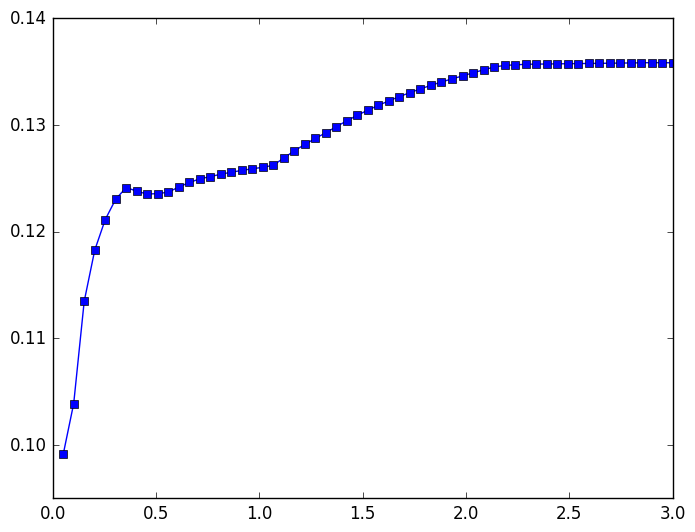

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32154fc10>

In [2]:
n = 100
thetas = randn(n) / sqrt(2)
vs = rand(n) * 4
cs = rand(n) * 20
zs = randn(n) ./ sqrt(vs) + thetas

mu_grid = linspace(0, 3, 60)
out = zeros(mu_grid)
for (ix, mu) in enumerate(mu_grid)
    out[ix] = dot(thetas, KP.q_l2reg(cs, zs, vs, mu)[1])/n
end

plot(mu_grid, out, "s-b")

### Constructing a good syntehtetic example

In [10]:
using Roots, Distributions
Phi(t) = cdf(Normal(), t)

In [128]:
#Assume the second theta/v is at 1, 1

theta_l = .01
v_l = .012
theta_h = 1.5
v_h = .1

#Determines the mixture quantile and proportions
function thresh(tau) 
    f(q) = Phi(q * (v_l+tau)/sqrt(v_l) - sqrt(v_l)*theta_l) + 
            Phi(q*(1+tau)-1) + 
            Phi(q * (v_h+tau)/sqrt(v_h) - sqrt(v_h)*theta_h) -
            3*.9
    qstar = fzero(f, [0, 10])
    (qstar, 10/3*(1-[Phi(qstar * (v_l+tau)/sqrt(v_l) - sqrt(v_l)*theta_l), 
        Phi(qstar*(1+tau)-1), 
        Phi(qstar * (v_h+tau)/sqrt(v_h) - sqrt(v_h)*theta_h)] ))
end    

#Estimate the optimal tau value w.r.t l2
n = 10002
thetas = ones(Float64, n)
thetas[1:n/3] = theta_l
thetas[2n/3:end] = theta_h

vs = ones(Float64, n)
vs[1:n/3] = v_l
vs[2n/3:end] = v_h

f(tau) = mean(-2*(vs + vs.^2 .* thetas.^2)./(vs + tau).^3 + 2*vs.*thetas.^2./(vs + tau).^2)

tau_l2  = fzero(f, [0, 5])
obj_l2 = dot(thresh(tau_l2)[2], [theta_l, 1, theta_h])


#Compute the oracle value of tau
tau_grid = linspace(0, .5, 20)
f(tau) = dot(thresh(tau)[2], [theta_l, 1, theta_h])
res = optimize(t-> -1*f(t), 0, 1)
tau_OR = Optim.minimizer(res)
obj_OR = Optim.minimum(res) * -1
tau_OR, obj_OR

tau_mm = 1/mean(thetas.^2)
obj_mm = dot(thresh(tau_mm)[2], [theta_l, 1, theta_h])

println("SAA:")
obj_SAA = dot(thresh(0.)[2], [theta_l, 1, theta_h])
println("0. \t $obj_SAA \t $(obj_SAA/obj_OR)")

println("L2:")
println("$tau_l2 \t $obj_l2 \t $(obj_l2/obj_OR)")

println("MM:")
println("$tau_mm \t $obj_mm \t $(obj_mm/obj_OR)")

println("Oracle:")
println("$tauOR \t $obj_OR")

SAA:
0. 	 0.3043642111134087 	 0.23855723309605797
L2:
0.6655953493673264 	 1.050951133828992 	 0.823723635864638
MM:
0.9229420528405273 	 1.0253531744997804 	 0.8036602442847166
Oracle:
0.14477894391818752 	 1.275854046273469


0.9016857524130816

(0.14477894391818752,1.3504776458079317)

In [88]:
using Optim

INFO: Recompiling stale cache file /Users/vishalgupta/.julia/lib/v0.4/Optim.ji for module Optim.
INFO: Recompiling stale cache file /Users/vishalgupta/.julia/lib/v0.4/PositiveFactorizations.ji for module PositiveFactorizations.
